In [1]:
import os
import requests
import zipfile
from tqdm.notebook import tqdm

url = "https://data.nasa.gov/docs/legacy/ai4mars-dataset-merged-0.1.zip"
zip_path = "ai4mars-dataset.zip"
extract_dir = "ai4mars-dataset"

# Download with progress bar
def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as f, tqdm(
        desc=dest_path,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            size = f.write(chunk)
            bar.update(size)

# Download if not already done
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    download_file(url, zip_path)
else:
    print("ZIP file already downloaded.")

# Unzip
if not os.path.exists(extract_dir):
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Done.")
else:
    print("Dataset already extracted.")


ai4mars-dataset.zip:   0%|          | 0.00/5.72G [00:00<?, ?iB/s]

Extracting...
Done.


In [2]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
walk_through(extract_dir)

There are 1 directories and 0 images in 'ai4mars-dataset'.
There are 2 directories and 1 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1'.
There are 2 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl'.
There are 2 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels'.
There are 3 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/test'.
There are 0 directories and 322 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/test/masked-gold-min2-100agree'.
There are 0 directories and 322 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/test/masked-gold-min3-100agree'.
There are 0 directories and 322 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/test/masked-gold-min1-100agree'.
There are 0 directories and 16064 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/train'.
There are 3 directories and 0 images in 'ai4mars-dataset/ai4mars-data

In [ ]:
import os
import shutil
import random
from tqdm.notebook import tqdm

# Input paths
root_dir = "ai4mars-dataset/ai4mars-dataset-merged-0.1/msl"
images_dir = os.path.join(root_dir, "images", "edr")
labels_dir = os.path.join(root_dir, "labels", "train")

# Output paths
subset_dir = "ai4mars-subset"
subset_images = os.path.join(subset_dir, "images")
subset_labels = os.path.join(subset_dir, "labels")

# Make output dirs
os.makedirs(subset_images, exist_ok=True)
os.makedirs(subset_labels, exist_ok=True)

# Build base filename sets
image_dict = {f.rsplit(".", 1)[0]: f for f in os.listdir(images_dir) if f.lower().endswith(".jpg")}
label_dict = {f.rsplit(".", 1)[0]: f for f in os.listdir(labels_dir) if f.lower().endswith(".png")}

# Intersection of base names
common_basenames = sorted(set(image_dict.keys()) & set(label_dict.keys()))
print(f"Found {len(common_basenames)} matched image-label pairs.")

# Select up to 5000
subset_size = min(5000, len(common_basenames))
subset_basenames = random.sample(common_basenames, subset_size)

# Copy matched files
print(f"Copying {subset_size} pairs to 'ai4mars-subset/'...")
for base in tqdm(subset_basenames):
    shutil.copy(os.path.join(images_dir, image_dict[base]), os.path.join(subset_images, image_dict[base]))
    shutil.copy(os.path.join(labels_dir, label_dict[base]), os.path.join(subset_labels, label_dict[base]))

print("Subset creation complete!")


✅ Found 16064 matched image-label pairs.
📦 Copying 5000 pairs to 'ai4mars-subset/'...


  0%|          | 0/5000 [00:00<?, ?it/s]

✅ Subset creation complete!


In [5]:
walk_through(subset_dir)

There are 2 directories and 0 images in 'ai4mars-subset'.
There are 0 directories and 5000 images in 'ai4mars-subset/labels'.
There are 0 directories and 5000 images in 'ai4mars-subset/images'.


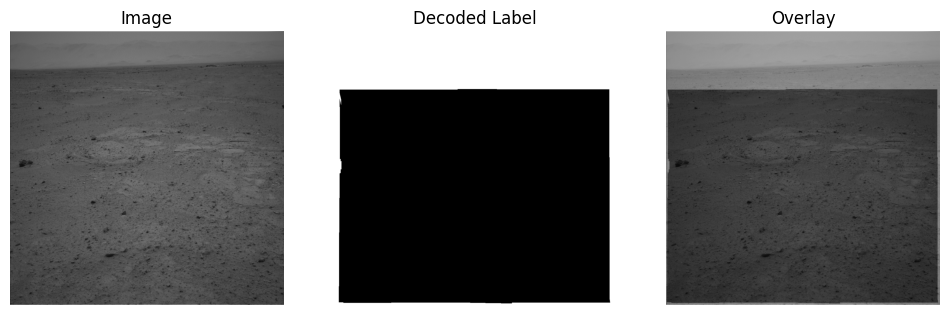

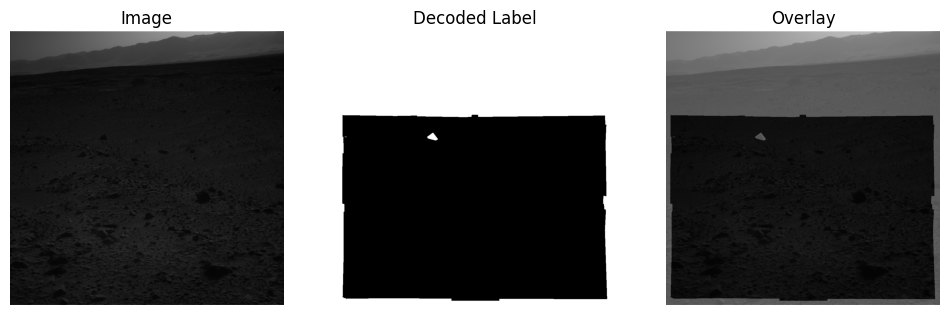

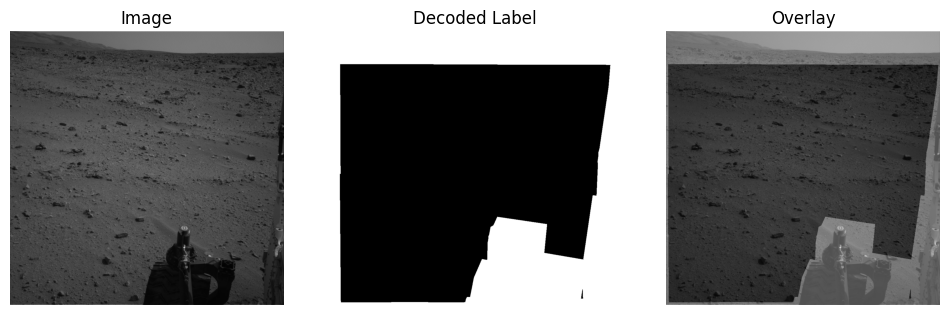

In [6]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Paths
subset_images = "ai4mars-subset/images"
subset_labels = "ai4mars-subset/labels"

# Get all matching base filenames
image_files = sorted([f for f in os.listdir(subset_images) if f.lower().endswith(".jpg")])
label_files = sorted([f for f in os.listdir(subset_labels) if f.lower().endswith(".png")])
base_names = sorted(set(f.rsplit('.', 1)[0] for f in image_files) &
                    set(f.rsplit('.', 1)[0] for f in label_files))

# Pick a few random pairs
sample_bases = random.sample(base_names, 3)

# Label class mapping (visual only)
label_colors = {
    0: [0, 0, 0],        # soil
    1: [100, 100, 100],  # bedrock
    2: [255, 255, 0],    # sand
    3: [255, 0, 0],      # big rock
    255: [255, 255, 255] # null (white)
}

def decode_label_mask(mask):
    decoded = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    for val, color in label_colors.items():
        decoded[(mask == val).all(axis=-1)] = color
    return decoded

# Display
for base in sample_bases:
    img_path = os.path.join(subset_images, base + ".JPG")
    lbl_path = os.path.join(subset_labels, base + ".png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label = cv2.imread(lbl_path)
    label = decode_label_mask(label)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label)
    plt.title("Decoded Label")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    overlay = cv2.addWeighted(img, 0.7, label, 0.3, 0)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch

In [8]:
RGB_CLASS_MAP = {
    (0, 0, 0): 0,           # soil
    (1, 1, 1): 1,           # bedrock
    (2, 2, 2): 2,           # sand
    (3, 3, 3): 3,           # big rock
    (255, 255, 255): 255    # ignore
}

In [9]:
def encode_mask(mask_img):
    mask_np = np.array(mask_img)
    h, w, _ = mask_np.shape
    label = np.ones((h, w), dtype=np.uint8) * 255  # default = ignore
    for rgb, idx in RGB_CLASS_MAP.items():
        matches = np.all(mask_np == rgb, axis=-1)
        label[matches] = idx
    return label

In [10]:

class MarsSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, img_size=256):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".JPG")])
        self.transform = transform
        self.img_size = img_size

        self.image_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img_name = self.images[idx]
      base_name = img_name.rsplit(".", 1)[0]
      label_name = base_name + ".png"

      # Load and resize
      img = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
      label_img = Image.open(os.path.join(self.label_dir, label_name)).convert("RGB")
      label_img = label_img.resize((self.img_size, self.img_size), resample=Image.NEAREST)

      # Encode label
      label = encode_mask(label_img)

      # Apply transforms
      img = self.image_transform(img)
      label = torch.from_numpy(label).long()

      return img, label


In [12]:
from torch.utils.data import random_split, DataLoader
# Full dataset (your 5k subset)
full_dataset = MarsSegmentationDataset(
    image_dir="ai4mars-subset/images",
    label_dir="ai4mars-subset/labels",
    img_size=256
)

# Split sizes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Random split
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7825a5188d50>,
 <torch.utils.data.dataloader.DataLoader at 0x7824d4477650>)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
import torchvision
import torch.nn as nn

# Load model
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

# Replace classifier with 4 output classes (soil, bedrock, sand, big rock)
model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, 4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 164MB/s]


In [15]:
model = model.to(device)

In [16]:
import torch.optim as optim

# Loss: CrossEntropy with ignore_index
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [17]:
from tqdm.notebook import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


In [18]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = outputs.argmax(1)
            valid = masks != 255
            correct += (preds[valid] == masks[valid]).sum().item()
            total += valid.sum().item()

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [19]:
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    scheduler.step()


Training:   0%|          | 0/500 [00:00<?, ?it/s]

[1/3] Train Loss: 0.3602 | Val Loss: 0.2650 | Val Acc: 90.64%


Training:   0%|          | 0/500 [00:00<?, ?it/s]

[2/3] Train Loss: 0.2372 | Val Loss: 0.2032 | Val Acc: 92.98%


Training:   0%|          | 0/500 [00:00<?, ?it/s]

[3/3] Train Loss: 0.1766 | Val Loss: 0.1610 | Val Acc: 94.57%


In [20]:
torch.save(model.state_dict(), "deeplabv3_mars.pth")


In [21]:
from google.colab import files
files.download("deeplabv3_mars.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>